# **Importing Data** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('/kaggle/input/videogamesales/vgsales.csv')
data.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rank          16598 non-null  int64  
 1   Name          16598 non-null  object 
 2   Platform      16598 non-null  object 
 3   Year          16327 non-null  float64
 4   Genre         16598 non-null  object 
 5   Publisher     16540 non-null  object 
 6   NA_Sales      16598 non-null  float64
 7   EU_Sales      16598 non-null  float64
 8   JP_Sales      16598 non-null  float64
 9   Other_Sales   16598 non-null  float64
 10  Global_Sales  16598 non-null  float64
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


In [4]:
data.isnull().sum()

Rank              0
Name              0
Platform          0
Year            271
Genre             0
Publisher        58
NA_Sales          0
EU_Sales          0
JP_Sales          0
Other_Sales       0
Global_Sales      0
dtype: int64

In [5]:
data.duplicated().sum()

0

# **Data preprocessing**

**Year Column**

In [6]:
null_inYear = ((data['Year'].isna().sum() / len(data)) * 100).round(2)
print(f"Missing percent of Year col is : ", null_inYear,"%")

Missing percent of Year col is :  1.63 %


We will investigate missing values by seeing relation between year and other relevant columns

In [7]:
data['Year_missing'] = data['Year'].isna().astype(int)


print(data.groupby('Platform')['Year_missing'].mean().sort_values(ascending=False))
print("\n**********************************\n")

print(data.groupby('Genre')['Year_missing'].mean().sort_values(ascending=False))
print("\n**********************************\n")

print(data.groupby('Publisher')['Year_missing'].mean().sort_values(ascending=False))

Platform
2600    0.127820
Wii     0.026415
XB      0.025485
GC      0.025180
X360    0.023715
PS3     0.018811
PC      0.017708
3DS     0.017682
PS2     0.015733
DS      0.013870
GBA     0.013382
PSP     0.013190
GB      0.010204
N64     0.009404
PS      0.005853
PSV     0.002421
3DO     0.000000
PCFX    0.000000
NG      0.000000
PS4     0.000000
NES     0.000000
SAT     0.000000
SCD     0.000000
SNES    0.000000
TG16    0.000000
WS      0.000000
GG      0.000000
WiiU    0.000000
GEN     0.000000
DC      0.000000
XOne    0.000000
Name: Year_missing, dtype: float64

**********************************

Genre
Shooter         0.021374
Action          0.018999
Puzzle          0.018900
Simulation      0.018454
Racing          0.018415
Sports          0.017903
Misc            0.016676
Strategy        0.014684
Fighting        0.014151
Role-Playing    0.011425
Platform        0.011287
Adventure       0.007776
Name: Year_missing, dtype: float64

**********************************

Publisher
Ultr

Now we will use chi-square test to test our hypothesis that the Year col is affected by Platform,Publisher cols

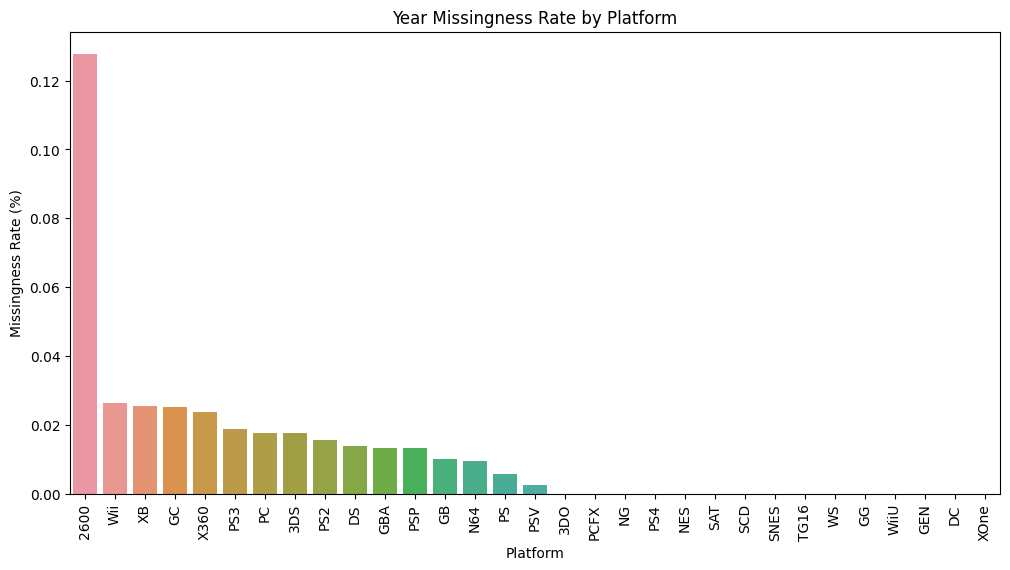

In [8]:
# Calculate missingness rate per platform
platform_missing = data.groupby("Platform")["Year"].apply(lambda x: x.isna().mean()).sort_values(ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x=platform_missing.index, y=platform_missing.values)
plt.xticks(rotation=90)
plt.ylabel("Missingness Rate (%)")
plt.xlabel("Platform")
plt.title("Year Missingness Rate by Platform")
plt.show()

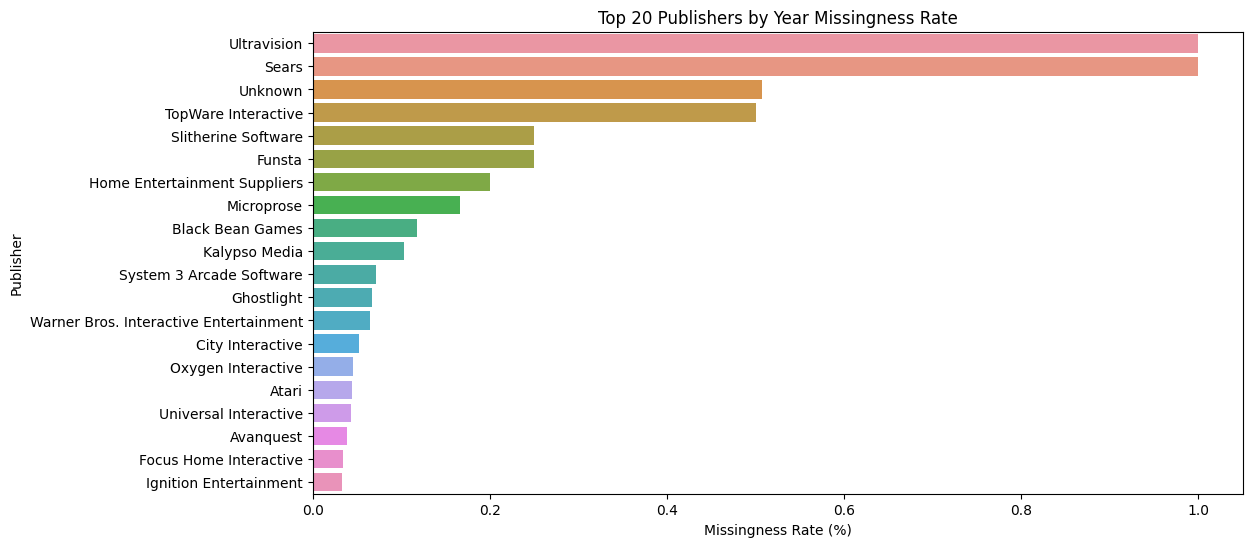

In [9]:
# Calculate missingness rate per publisher
publisher_missing = data.groupby("Publisher")["Year"].apply(lambda x: x.isna().mean())

# Take top 20 publishers 
publisher_top = publisher_missing.sort_values(ascending=False).head(20)

plt.figure(figsize=(12,6))
sns.barplot(y=publisher_top.index, x=publisher_top.values)
plt.xlabel("Missingness Rate (%)")
plt.title("Top 20 Publishers by Year Missingness Rate")
plt.show()

In [10]:
from scipy.stats import chi2_contingency


contingency_genre = pd.crosstab(data['Publisher'], data['Year_missing'])
chi2_genre, p_genre, dof_genre, expected_genre = chi2_contingency(contingency_genre)

print(f"Chi-squared test for Publisher and Year missingness:")
print(f"Chi2 Statistic: {chi2_genre}")
print(f"P-value: {p_genre}")
print("-" * 30)


contingency_platform = pd.crosstab(data['Platform'], data['Year_missing'])
chi2_platform, p_platform, dof_platform, expected_platform = chi2_contingency(contingency_platform)

print(f"Chi-squared test for Platform and Year missingness:")
print(f"Chi2 Statistic: {chi2_platform}")
print(f"P-value: {p_platform}")

Chi-squared test for Publisher and Year missingness:
Chi2 Statistic: 3795.436081451183
P-value: 0.0
------------------------------
Chi-squared test for Platform and Year missingness:
Chi2 Statistic: 161.48030113668653
P-value: 5.959771732529095e-20


Coclusion:
1. when Publisher is missing, Year is often missing too (not independent)
2. There’s also a strong dependency between Platform missingness and Year missingness, though not as dramatic as with Publisher.
   

We will fill the Year col with col median by now so we dont drop any relevant information while also be able to visualize trends

In [11]:
data['Year'] = data['Year'].fillna(data['Year'].median()).astype(int)
data['Year'].isna().sum()

0

**Publisher Column**

In [12]:
null_inPublisher = ((data['Publisher'].isna().sum() / len(data)) * 100).round(2)
print(f"Missing percent of Publisher col is : ", null_inPublisher,"%")

Missing percent of Publisher col is :  0.35 %


We will investigate missing values by seeing relation between year and other relevant columns

In [13]:
data['Publisher_missing'] = data['Publisher'].isna()


platform_missing = data.groupby('Platform')['Publisher_missing'].mean().sort_values(ascending=False)
print(platform_missing[platform_missing > 0])
print("\n**********************************\n")

genre_missing = data.groupby('Genre')['Publisher_missing'].mean().sort_values(ascending=False)
print(genre_missing[genre_missing > 0])
print("\n**********************************\n")

year_missing = data.groupby('Year')['Publisher_missing'].mean().sort_values(ascending=False)
print(year_missing[year_missing > 0])

Platform
GBA     0.031630
PC      0.006250
PSV     0.004843
3DS     0.003929
DS      0.003236
X360    0.003162
PS      0.002508
PS3     0.002257
PSP     0.001649
PS2     0.000925
Wii     0.000755
Name: Publisher_missing, dtype: float64

**********************************

Genre
Misc            0.015526
Simulation      0.004614
Strategy        0.004405
Adventure       0.003110
Fighting        0.002358
Platform        0.002257
Action          0.002111
Puzzle          0.001718
Shooter         0.001527
Role-Playing    0.001344
Sports          0.001279
Racing          0.000801
Name: Publisher_missing, dtype: float64

**********************************

Year
2004    0.024902
2007    0.015614
2016    0.005814
2005    0.005313
2014    0.003436
2012    0.003044
2011    0.002634
2010    0.001589
Name: Publisher_missing, dtype: float64


**Conclusion:**


1. The majority of missing publisher names come from mid-2000s releases (esp. 2004), primarily on platforms like GBA(3.2%) and PC(0.6%).
2. This suggests the missingness isn’t random but instead reflects incomplete archival of games from that era, particularly handheld and miscellaneous titles.


# **Feature engineering**

create a decade column to visualize trends through decades not just years

In [14]:
data['Decade'] = (data['Year'] // 10) * 10

create region shares percentage of the global shares

In [15]:
data['NA_Share'] = data['NA_Sales'] / data['Global_Sales']
data['EU_Share'] = data['EU_Sales'] / data['Global_Sales']
data['JP_Share'] = data['JP_Sales'] / data['Global_Sales']
data['Other_Share'] = data['Other_Sales'] / data['Global_Sales']

In [16]:
data.isna().sum()

Rank                  0
Name                  0
Platform              0
Year                  0
Genre                 0
Publisher            58
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Year_missing          0
Publisher_missing     0
Decade                0
NA_Share              0
EU_Share              0
JP_Share              0
Other_Share           0
dtype: int64

# **EDA**

# What are the top-selling genres globally and within each region (NA, EU, JP, Other)?

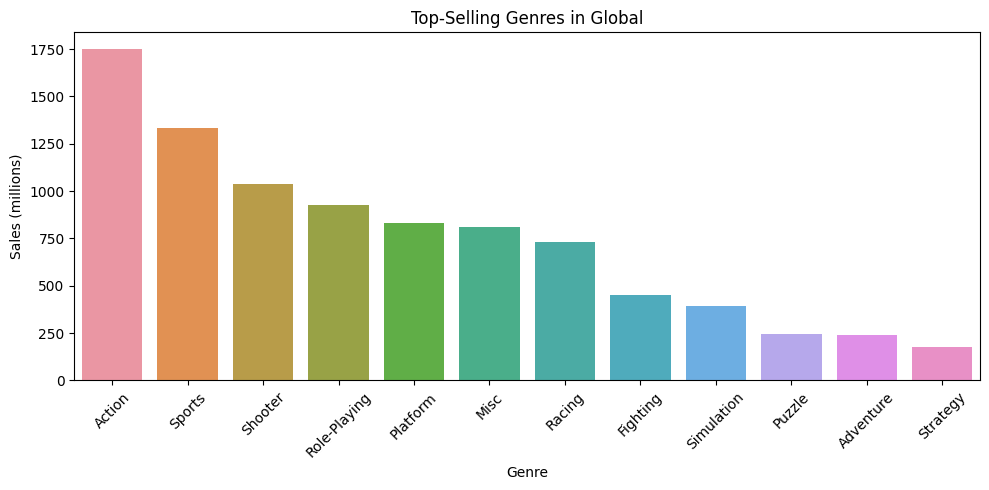

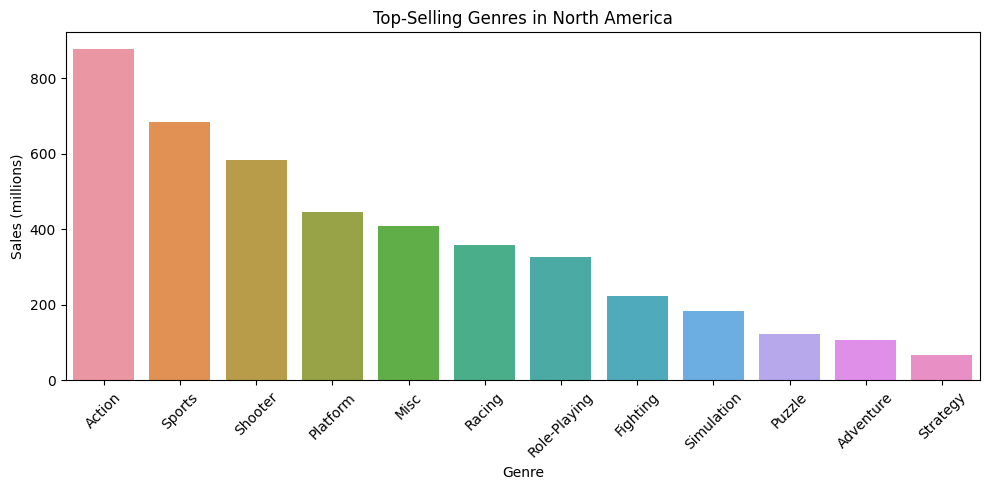

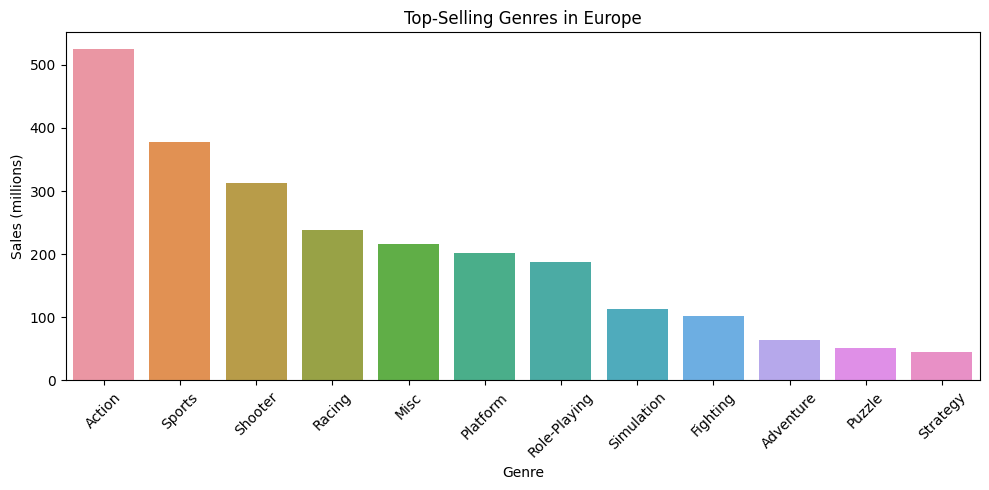

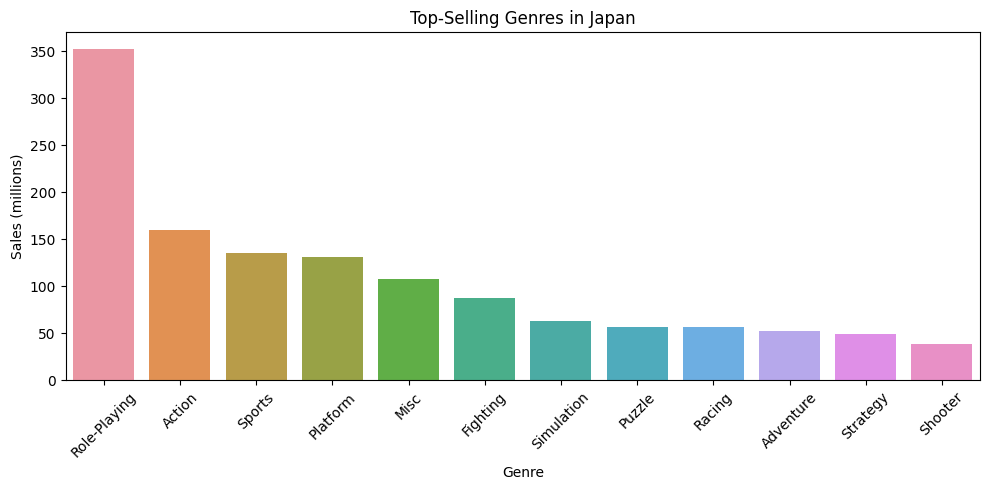

In [17]:
top_selling = data.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)
top_selling_na = data.groupby('Genre')['NA_Sales'].sum().sort_values(ascending=False)
top_selling_eu = data.groupby('Genre')['EU_Sales'].sum().sort_values(ascending=False)
top_selling_jp = data.groupby('Genre')['JP_Sales'].sum().sort_values(ascending=False)


sales_dict = {
    "Global": top_selling,
    "North America": top_selling_na,
    "Europe": top_selling_eu,
    "Japan": top_selling_jp
}

for region, values in sales_dict.items():
    plt.figure(figsize=(10,5))
    sns.barplot(x=values.index, y=values.values)
    plt.xticks(rotation=45)
    plt.ylabel('Sales (millions)')
    plt.title(f"Top-Selling Genres in {region}")
    plt.tight_layout()
    plt.show()


# What are total sales by genre, platform, and publisher ?

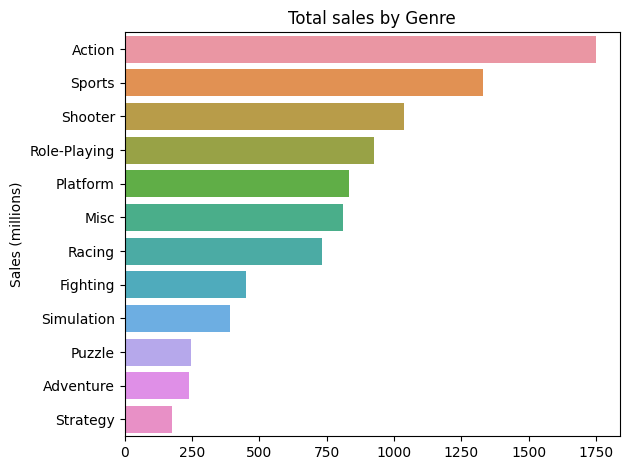

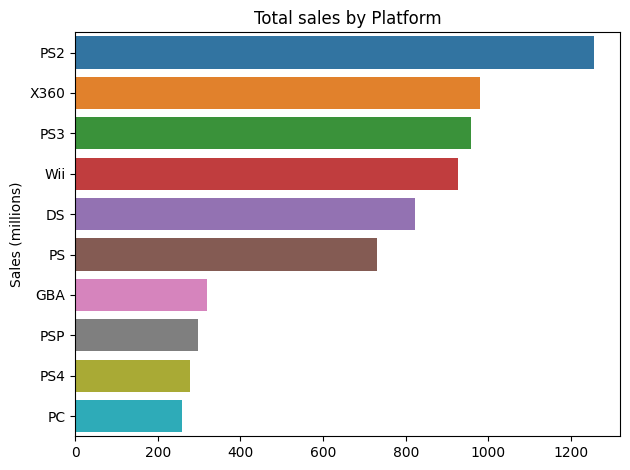

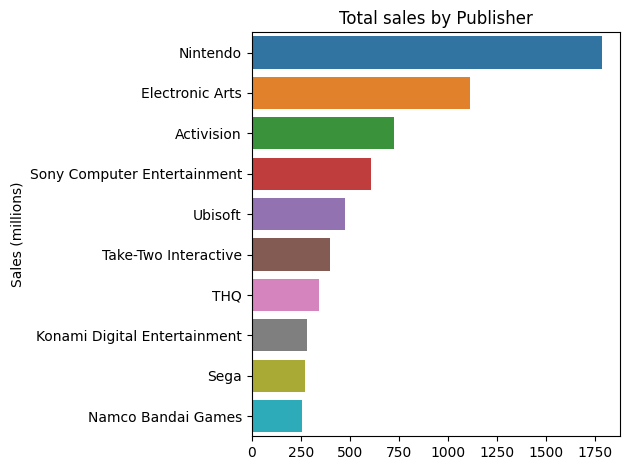

In [18]:
top_selling_genre = data.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=False)
top_selling_platform = data.groupby('Platform')['Global_Sales'].sum().nlargest(10).sort_values(ascending=False)
top_selling_publisher = data.groupby('Publisher')['Global_Sales'].sum().nlargest(10).sort_values(ascending=False)

sales_dict = {
    "Genre": top_selling_genre,
    "Platform": top_selling_platform,
    "Publisher": top_selling_publisher
}

for category, values in sales_dict.items():
    sns.barplot(x=values.values, y=values.index)
    plt.ylabel('Sales (millions)')
    plt.title(f"Total sales by {category}")
    plt.tight_layout()
    plt.show()

# Sales trends over time

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


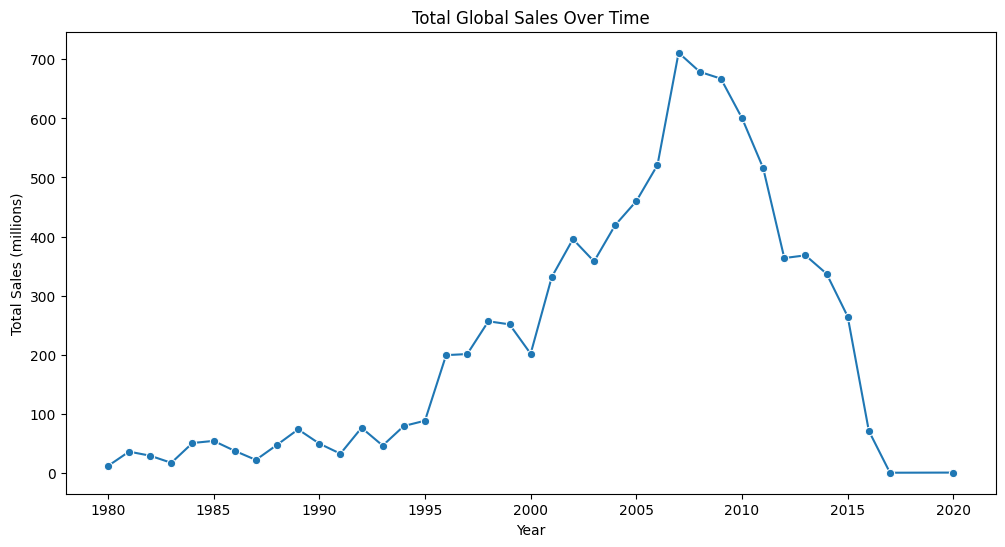

In [19]:
sales_per_year = data.groupby('Year')['Global_Sales'].sum().reset_index()


plt.figure(figsize=(12,6))
sns.lineplot(data=sales_per_year, x='Year', y='Global_Sales',marker="o")
plt.title("Total Global Sales Over Time")
plt.xlabel("Year")
plt.ylabel("Total Sales (millions)")
plt.show()

# Sales trends over decades

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


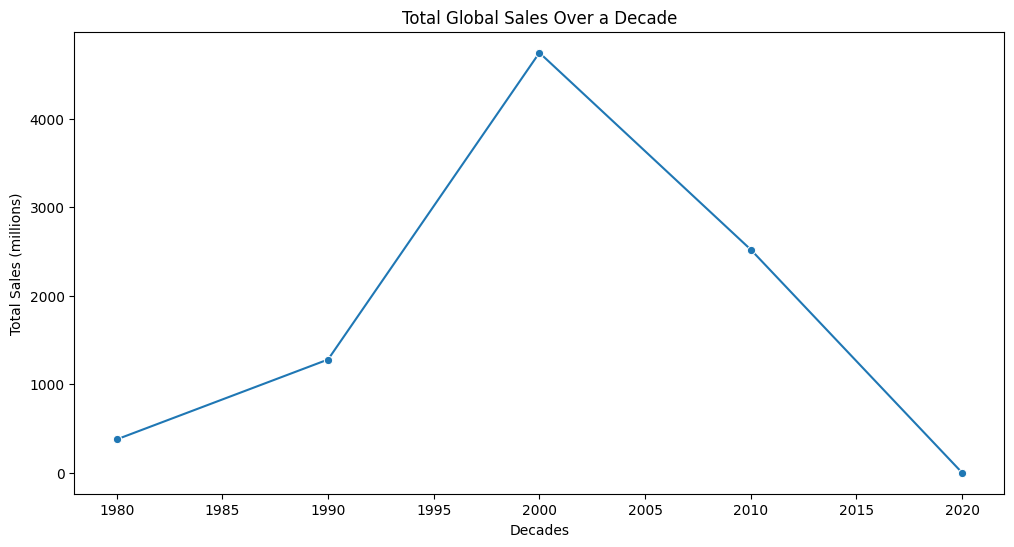

In [20]:
sales_per_decade = data.groupby('Decade')['Global_Sales'].sum().reset_index()


plt.figure(figsize=(12,6))
sns.lineplot(data=sales_per_decade, x='Decade', y='Global_Sales',marker="o")
plt.title("Total Global Sales Over a Decade")
plt.xlabel("Decades")
plt.ylabel("Total Sales (millions)")
plt.show()

# What are the top 10 best selling video games ?


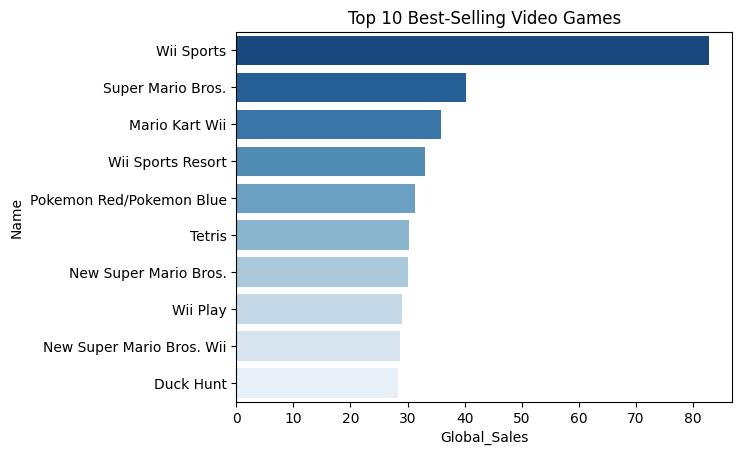

In [21]:
top10 = data.nlargest(10, 'Global_Sales')
sns.barplot(data=top10, x='Global_Sales', y='Name', palette="Blues_r")
plt.title("Top 10 Best-Selling Video Games")
plt.show()

# What are the Top 10 Publishers by Number of Games with Genre Breakdown


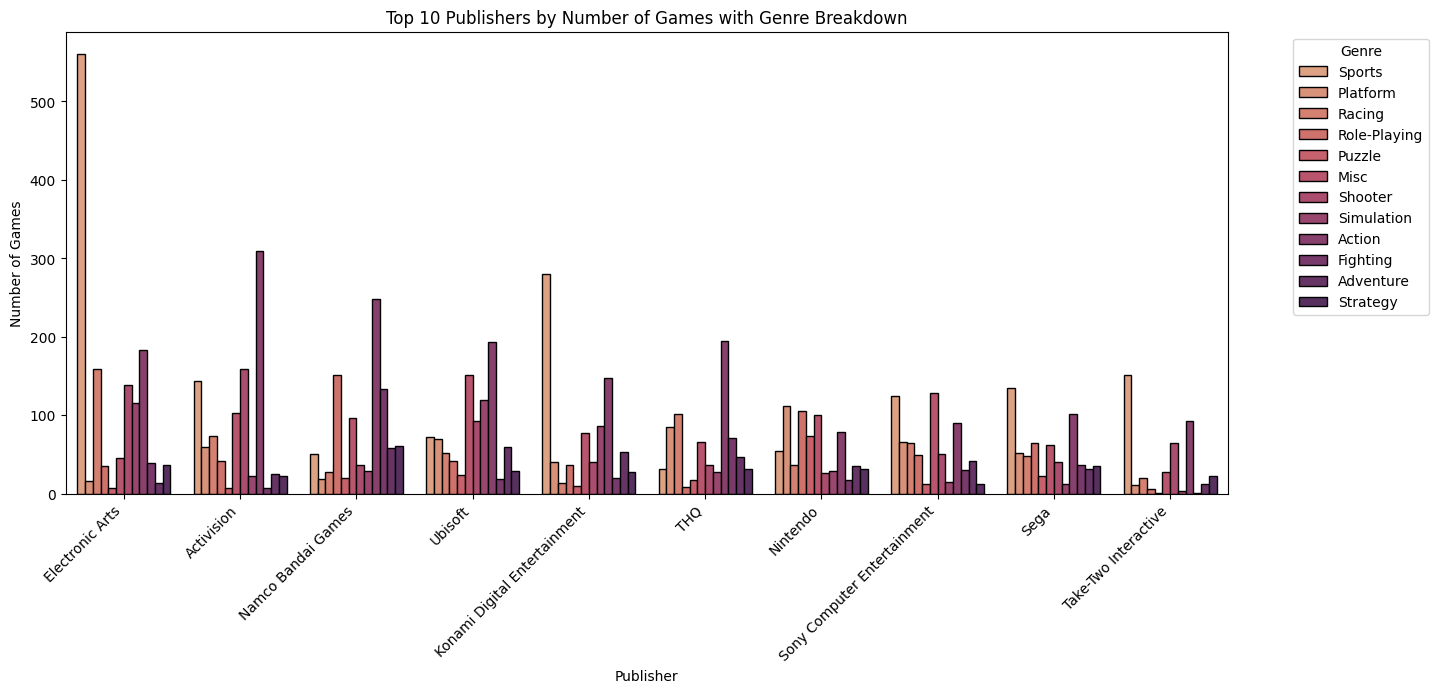

In [22]:
publisher_order=data["Publisher"].value_counts().nlargest(10).index

plt.figure(figsize=(15,6))
sns.countplot(data=data, x='Publisher', hue='Genre',edgecolor='black',palette='flare',order = publisher_order)
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Games")
plt.title("Top 10 Publishers by Number of Games with Genre Breakdown")
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')

# Correlation between each region and global


<Axes: >

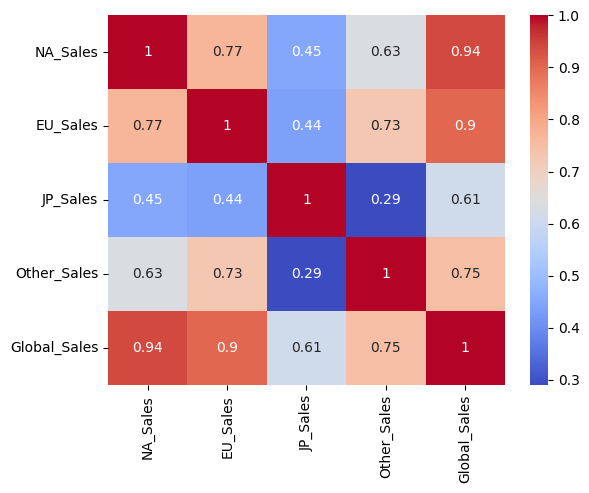

In [23]:
corr_data = data[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]

corr = corr_data.corr()
sns.heatmap(corr,annot=True,cmap="coolwarm")

# What is the average sale share per region from global sales ?

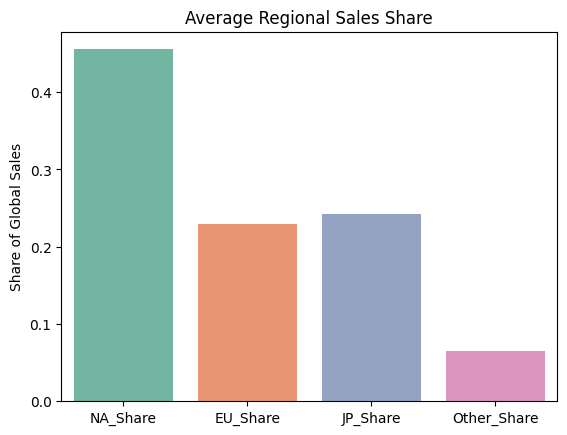

In [24]:
region_means = data[['NA_Share','EU_Share','JP_Share','Other_Share']].mean()
sns.barplot(x=region_means.index, y=region_means.values, palette="Set2")
plt.title("Average Regional Sales Share")
plt.ylabel("Share of Global Sales")
plt.show()

# Do newer platforms replace older ones gradually, or is there an overlap in success?


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

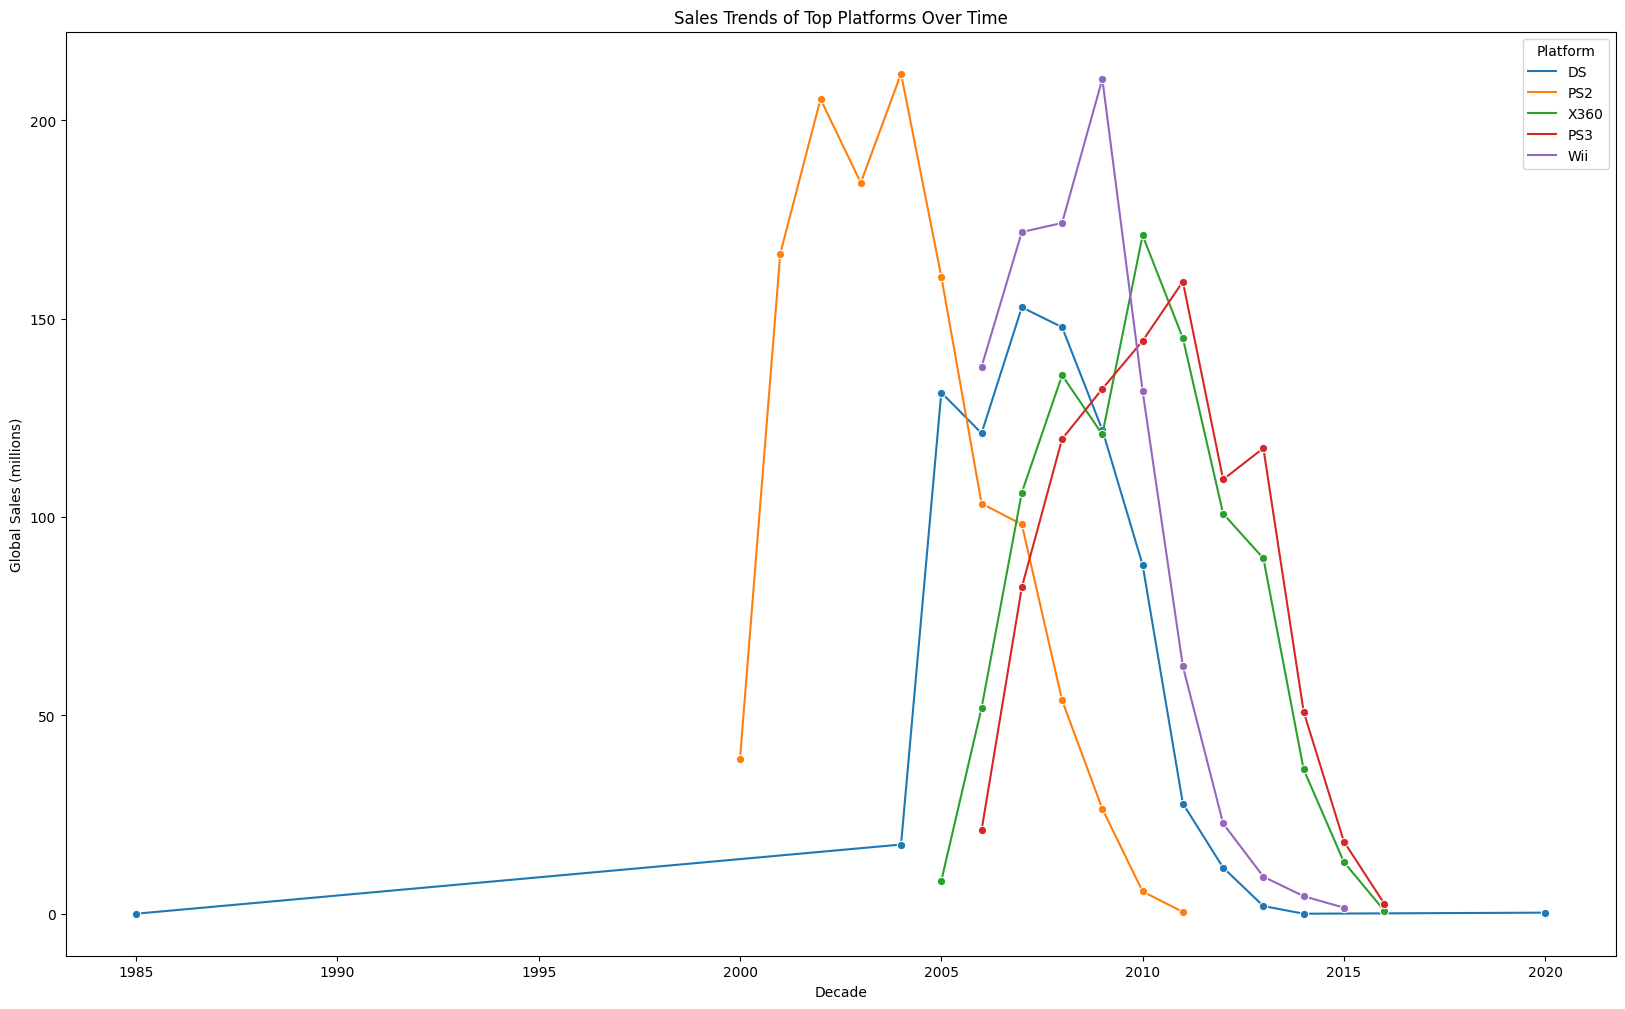

In [25]:
platform_year_sales = data.groupby(['Year','Platform'])['Global_Sales'].sum().reset_index()

top_platforms = data.groupby('Platform')['Global_Sales'].sum().nlargest(5).index

platform_year_sales_top = platform_year_sales[platform_year_sales['Platform'].isin(top_platforms)]



plt.figure(figsize=(20,12))
sns.lineplot(data=platform_year_sales_top,
    x='Year',
    y='Global_Sales',
    hue='Platform',
    marker='o')

plt.title("Sales Trends of Top Platforms Over Time")
plt.xlabel("Decade")
plt.ylabel("Global Sales (millions)")
plt.legend(title='Platform')
plt.show()